In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset paths
REAL_PATH = r"D:\Projects\DeepFake_Detection\input__data\DFD_original sequences"
FAKE_PATH = r"D:\Projects\DeepFake_Detection\input__data\DFD_manipulated_sequences"
OUTPUT_FRAME_SIZE = (128, 128)  # Frame dimensions
FRAME_COUNT = 10  # Number of frames to extract per video
MAX_VIDEOS = 700  # Number of videos to process from each category

# Function to extract frames from a video
def extract_frames(video_path, output_size=(128, 128), frame_count=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)  # Uniform sampling
    
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

# Prepare data and labels
data = []
labels = []

# Process real videos
print("Processing real videos...")
real_videos = os.listdir(REAL_PATH)[:MAX_VIDEOS]   # Limit to 300 videos
for video_file in tqdm(real_videos):
    video_path = os.path.join(REAL_PATH, video_file)
    frames = extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT)
    if len(frames) == FRAME_COUNT:  # Ensure correct frame count
        data.append(frames)
        labels.append(0)  # Label 0 for real

# Process fake videos
print("Processing fake videos...")
fake_videos = os.listdir(FAKE_PATH)[:MAX_VIDEOS]  # Limit to 300 videos
for video_file in tqdm(fake_videos):
    video_path = os.path.join(FAKE_PATH, video_file)
    frames = extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT)
    if len(frames) == FRAME_COUNT:
        data.append(frames)
        labels.append(1)  # Label 1 for fake

# Convert to numpy arrays
data = np.array(data)  # Shape: (num_videos, num_frames, 128, 128, 3)
labels = np.array(labels)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Data shapes: Train - {X_train.shape}, Validation - {X_val.shape}, Test - {X_test.shape}")


Processing real videos...


100%|██████████| 364/364 [05:56<00:00,  1.02it/s]


Processing fake videos...


100%|██████████| 700/700 [11:38<00:00,  1.00it/s]


Data shapes: Train - (744, 10, 128, 128, 3), Validation - (159, 10, 128, 128, 3), Test - (160, 10, 128, 128, 3)


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augment frames
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2]
)

# Function to augment extracted frames
def augment_frames(frames):
    augmented_frames = []
    for frame in frames:
        frame = datagen.random_transform(frame)
        augmented_frames.append(frame)
    return np.array(augmented_frames)

# Augment training data
augmented_data = []
augmented_labels = []

for i in range(len(X_train)):
    augmented_frames = augment_frames(X_train[i])
    augmented_data.append(augmented_frames)
    augmented_labels.append(y_train[i])

# Combine original and augmented data
X_train_augmented = np.concatenate((X_train, np.array(augmented_data)))
y_train_augmented = np.concatenate((y_train, np.array(augmented_labels)))

print(f"Augmented Train Data: {X_train_augmented.shape}")


Augmented Train Data: (1488, 10, 128, 128, 3)


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

# Define model
def build_improved_model(input_shape=(FRAME_COUNT, 128, 128, 3)):
    model = Sequential([
        TimeDistributed(Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))),
        TimeDistributed(Flatten()),
        Dropout(0.5),  # Add dropout for regularization
        LSTM(128, return_sequences=False),
        Dropout(0.5),  # Add dropout
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_improved_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Model checkpoint to save the best model in .keras format
checkpoint = ModelCheckpoint(
    "deepfake_detection_model.keras",  # Change to .keras
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Reduce learning rate on plateau
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_augmented, y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=10,
    callbacks=[checkpoint, lr_scheduler]
)
model.save("deepfake_detection_model.keras")

Epoch 1/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6563 - loss: 0.6699
Epoch 1: val_accuracy improved from -inf to 0.75472, saving model to deepfake_detection_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 955s 6s/step - accuracy: 0.6564 - loss: 0.6697 - val_accuracy: 0.7547 - val_loss: 0.5547 - learning_rate: 1.0000e-04
Epoch 2/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7073 - loss: 0.5891
Epoch 2: val_accuracy improved from 0.75472 to 0.85535, saving model to deepfake_detection_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 876s 6s/step - accuracy: 0.7075 - loss: 0.5889 - val_accuracy: 0.8553 - val_loss: 0.3816 - learning_rate: 1.0000e-04
Epoch 3/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7802 - loss: 0.4923
Epoch 3: val_accuracy improved from 0.85535 to 0.90566, saving model to deepfake_detection_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 880s 6s/step - accuracy: 0.7802 - loss: 0.4924 - val_accuracy: 0.9057 - val_loss: 0.3055 - learning_rate: 1.0000e-04
E

In [5]:
from sklearn.metrics import classification_report, accuracy_score

# Load the best saved model
from tensorflow.keras.models import load_model
model = load_model('deepfake_detection_model.keras')

# Evaluate on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Precision, Recall, F1-Score
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['REAL', 'FAKE']))

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step
Test Accuracy: 92.50%
Classification Report:
              precision    recall  f1-score   support

        REAL       0.96      0.82      0.88        55
        FAKE       0.91      0.98      0.94       105

    accuracy                           0.93       160
   macro avg       0.93      0.90      0.91       160
weighted avg       0.93      0.93      0.92       160



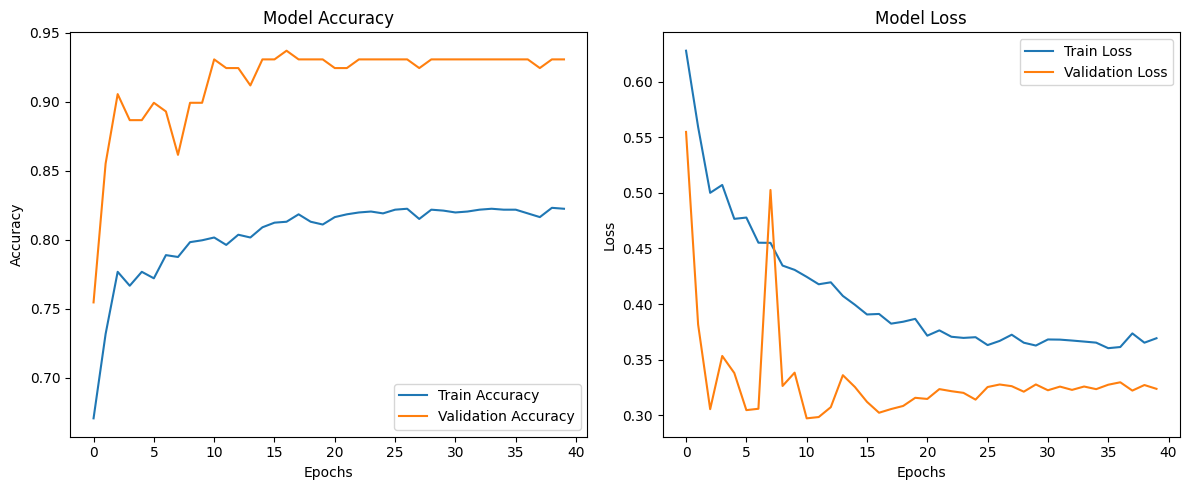

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


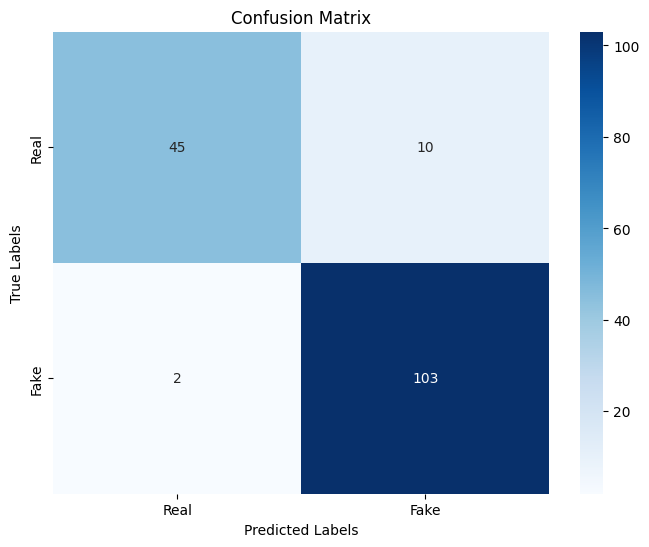

              precision    recall  f1-score   support

        Real       0.96      0.82      0.88        55
        Fake       0.91      0.98      0.94       105

    accuracy                           0.93       160
   macro avg       0.93      0.90      0.91       160
weighted avg       0.93      0.93      0.92       160



In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Plot accuracy and loss graphs
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Compute confusion matrix
def plot_confusion_matrix(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    cm_labels = ['Real', 'Fake']

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred_classes, target_names=cm_labels))

# Plot training history
plot_training_history(history)

# Plot confusion matrix
plot_confusion_matrix(model, X_test, y_test)


In [7]:
#Real Test

import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# Function to extract frames from a video
def extract_frames(video_path, output_size=(128, 128), frame_count=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)  # Uniform sampling
    
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

In [9]:
from tensorflow.keras.models import load_model

# Load the model for real-time detection
loaded_model = load_model('deepfake_detection_model.keras')

def predict_video(video_path, model, output_size=(128, 128), frame_count=10):
    frames = extract_frames(video_path, output_size, frame_count)
    frames = frames / 255.0  # Normalize
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    prediction = model.predict(frames)
    label = "FAKE" if np.argmax(prediction) == 1 else "REAL"
    confidence = prediction[0][np.argmax(prediction)]
    print(f"Prediction: {label} (Confidence: {confidence:.2f})")
    
REAL_PATH = r"D:\Projects\DeepFake_Detection\input__data\real"
FAKE_PATH = r"D:\Projects\DeepFake_Detection\input__data\fake"
# Test prediction on a video
real_sample_path = os.path.join(REAL_PATH, "/kaggle/input/deepfake-testing-videos/model1.mp4")  # Replace with real video path
fake_sample_path = os.path.join(FAKE_PATH, "/kaggle/input/deepfake-testing-videos/modeloutput1.mp4")  # Replace with fake video path

print("Real Video Prediction:")
predict_video(real_sample_path,loaded_model)

print("Fake Video Prediction:")
predict_video(fake_sample_path,loaded_model)

Real Video Prediction:


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(1, 0), dtype=float32). Expected shape (None, 10, 128, 128, 3), but input has incompatible shape (1, 0)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 0), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>